### TEST DIFFERENTS INVERSE METHODS APPROACHES

This notebook is intended to test different algorithms for the inverse estimation of the macroscopical parameters of porous materials. It can be applied considerig various analytical models in the minimization of the cost function such as JCA, JCAL, HS,... (more to be added). All of them are based on the measured absorption curve but it can be also implemented with the acoustic surface impedance.
Among the different algorithms tested are Non-linear least square, Genetic Algorithms and Neural Network. 

The fitness of the methods is evaluated with the Mean Squared Error (MSE). 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load the YM dataset
samples_abs_df = pd.read_csv('YM22_dataset.csv')   #Dataframe previously created with the measured data
samples_abs_df['abs_avg'] = samples_abs_df['abs_avg'].apply(lambda x: list(map(float, x.split(', '))))
samples_abs_df['abs_std'] = samples_abs_df['abs_std'].apply(lambda x: list(map(float, x.split(', '))))
samples_abs_df['freq'] = samples_abs_df['freq'].apply(lambda x: list(map(float, x.split(', '))))
samples_abs_df = samples_abs_df.set_index('sample')
samples_abs_df.head()

abs_avg  \
sample                                                             
YM2_coarse_d1  [0.039723884896938205, 0.002417451425838067, 0...   
YM2_coarse_d2  [-0.0669948242303281, -0.0859579715975053, -0....   
YM2_coarse_d3  [-0.07065207454509374, -0.0686334680643509, -0...   
YM2_medium_d1  [-0.058386349077054055, -0.046346527658788966,...   
YM2_medium_d2  [-0.05050127319899344, -0.054773154837570746, ...   

                                                         abs_std density  \
sample                                                                     
YM2_coarse_d1  [0.06316451781497398, 0.06769602259293946, 0.0...      d1   
YM2_coarse_d2  [0.034873367576951024, 0.03755932522197837, 0....      d2   
YM2_coarse_d3  [0.06553037290143565, 0.0664183338822305, 0.07...      d3   
YM2_medium_d1  [0.04037328132863594, 0.03260077798092913, 0.0...      d1   
YM2_medium_d2  [0.0393997605113044, 0.039389552427834096, 0.0...      d2   

               granul  thickness   mass  resflux  dens_value  \
sample                                                         
YM2_coarse_d1  coarse      43.67  21.16      0.0       76.17   
YM2_coarse_d2  coarse      38.67  19.51      0.0       79.32   
YM2_coarse_d3  coarse      34.67  17.63      0.0       79.97   
YM2_medium_d1  medium      44.33  20.04      0.0       71.04   
YM2_medium_d2  medium      39.33  21.24      0.0       84.91   

                                                            freq  
sample                                                            
YM2_coarse_d1  [100.0, 100.781, 101.563, 102.344, 103.125, 10...  
YM2_coarse_d2  [100.0, 100.781, 101.563, 102.344, 103.125, 10...  
YM2_coarse_d3  [100.0, 100.781, 101.563, 102.344, 103.125, 10...  
YM2_medium_d1  [100.0, 100.781, 101.563, 102.344, 103.125, 10...  
YM2_medium_d2  [100.0, 100.781, 101.563, 102.344, 103.125, 10...

In [2]:
selected_sample= samples_abs_df.loc['YM2_coarse_d1']   #Sample selection according to the index name of the dataframe

xdata = np.array(selected_sample['freq'])
ydata = np.array(selected_sample['abs_avg'])
sample_thick = (selected_sample['thickness']*1e-3)

In [3]:
#!pip install pygad

Optimal parameters: phi = 0.34073709801949786, alpha_inf = 2.156189027158377, sigma = 27545.19742444639, lamb = 0.0009999996239981835, lambpr = 0.0002146221406022671


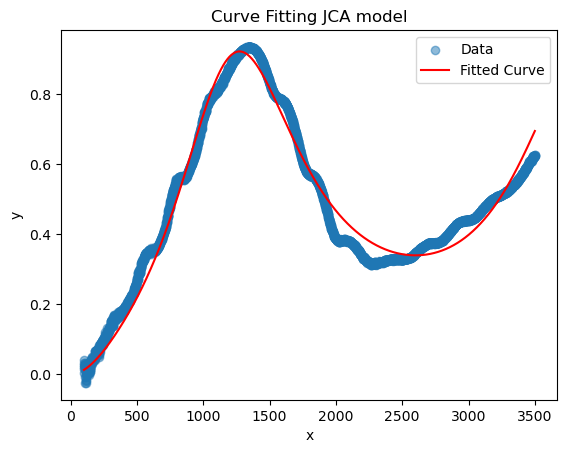

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from invmethods import *

###----------------------------INPUT--------------------------------###

# Macroscopical parameters: initial guess and bounds:

initial_guess = [0.76, 1.83, 2284, 83e-6, 67e-6, 0.22]  # Initial guess for parameters [phi, alpha_inf, sigma, lambda, lambda_prima, dev_por]
#Constrains:
lb = [0.1, 1, 500, 0.22e-6, 0.22e-6, 0.18]  # Lower bound of parameters
ub = [0.99, 10, 100000, 1000e-6, 1000e-6, 0.24]  # Upper bound of parameters

###-----------------------------------------------------------------###


#NON LINEAR LEAST SQUARE MINIMIZATION

#with JCA model
def wrapper(f, *params):
    #a,b,c,de,e = params
    d = sample_thick
    return myfun_jca(f, *params, d)

# Constraints for JCA model
lb_jca = lb[:-1]  # Lower bound of parameters
ub_jca = ub[:-1]  # Upper bound of parameters
initial_guess_jca = initial_guess[:-1]

optimal_params, covariance = curve_fit(wrapper, xdata, ydata, p0=initial_guess_jca, bounds=(lb_jca, ub_jca))

# Extract optimal parameters
a_fit, b_fit, c_fit, d_fit, e_fit = optimal_params
print(f"Optimal parameters: phi = {a_fit}, alpha_inf = {b_fit}, sigma = {c_fit}, lamb = {d_fit}, lambpr = {e_fit}")

# Plotting the results
plt.scatter(xdata, ydata, label='Data', alpha=0.5)
yfit_ls=myfun_jca(xdata, *optimal_params, sample_thick)
MSE_ls_jca = np.mean((ydata-yfit_ls)**2)

plt.plot(xdata, yfit_ls, color='red', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Curve Fitting JCA model')
plt.show()

In [5]:
#!pip install deap

Optimal parameters: phi = 0.5081785276202742, alpha_inf = 1.9092794355819989, sigma = 6161.577845678777, d_por = 0.18000000000000002


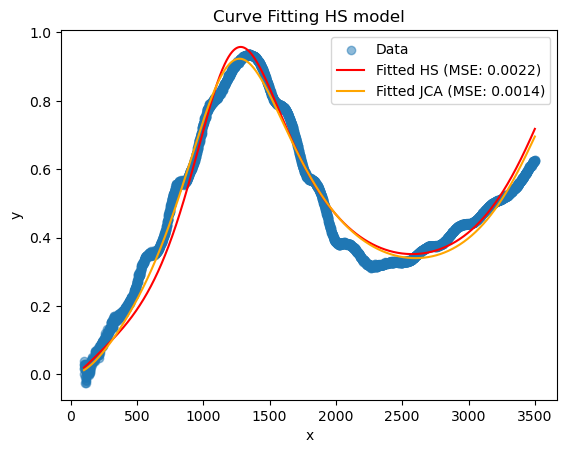

In [6]:
#with HS model

def wrapper(f, *params):
    d = sample_thick
    return myfun_hs(f, *params, d)
 
# Use curve_fit to minimize the cost function and fit the model to the data
initial_guess_hs = [0.76, 1.83, 5284, 0.22]  # Initial guess for parameters [phi, alpha_inf, sigma, lambda, lambda_prima]

# Constraints for HS model
lb_hs = lb[:-3] + lb[-1:]  # Lower bound of parameters
ub_hs = ub[:-3] + ub[-1:]  # Upper bound of parameters

optimal_params_hs, covariance_hs = curve_fit(wrapper, xdata, ydata, p0=initial_guess_hs, bounds=(lb_hs, ub_hs))

# Extract optimal parameters
a_fit, b_fit, c_fit, d_fit = optimal_params_hs
print(f"Optimal parameters: phi = {a_fit}, alpha_inf = {b_fit}, sigma = {c_fit}, d_por = {d_fit}")

# Plotting the results
plt.scatter(xdata, ydata, label='Data', alpha=0.5)
yfit_hs=myfun_hs(xdata, *optimal_params_hs, sample_thick)
MSE_ls_hs = np.mean((ydata-yfit_hs)**2)

plt.plot(xdata, yfit_hs, color='red', label=f'Fitted HS (MSE: {MSE_ls_hs.round(4)})')
plt.plot(xdata, yfit_ls, color='orange', label=f'Fitted JCA (MSE: {MSE_ls_jca.round(4)})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Curve Fitting HS model')
plt.show()

[0.36272860532818785, 9.79635863530389, 40660.45842544098, 0.0005303072030179614, 0.0008012275999218512]
[0.7132949927070438, 6.122786609640996, 28477.465243326784, 7.914499412140747e-05, 0.0009254288912993861]
[0.19423859780355934, 7.786748626609928, 57765.947436989496, 0.0009057767950070393, 0.0007126530909894171]
[0.9219953189855545, 3.6451492122209617, 44458.86379928091, 0.0005749887088567752, 0.0001259493511193321]
[0.435415433648223, 4.162884718252474, 97523.67751733474, 0.0005411247849063758, 0.0008383835842420312]
[0.7598715968393664, 3.2083956169061123, 48069.4650139066, 0.00014110651600905737, 0.00032805556154019764]
[0.22932861456775575, 2.7242759025276797, 15615.363707176302, 1.4049285304039644e-05, 0.0005325656078985872]
[0.28569270234520594, 7.4671587128363015, 951.8422244362895, 7.596439083534326e-05, 0.0006574944067456931]
[0.12301151422499781, 3.144863324604768, 90697.99753347947, 0.000998284616443056, 0.0007716024586975433]
[0.7699333561991037, 3.258076511550479, 1760

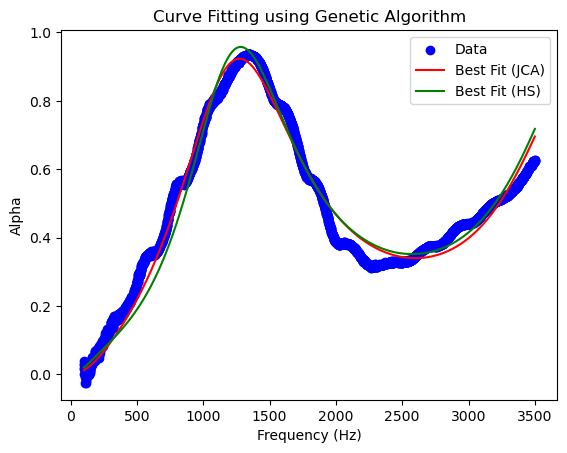

In [7]:
#Implementing a Non-Gradient Approach: Genetic Algorithm Example with DEAP

import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

model = 'JCA'

# Define the cost function

# Set up DEAP for genetic algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
if model == 'JCA':
    
    def cost_function(individual):
        print(individual)
        #a, b, c, d, e = individual
        predictions = myfun_jca(xdata, *individual, sample_thick)
        cost = np.mean((ydata - predictions) ** 2)
        return (cost,)

    toolbox.register("a", np.random.uniform, lb[0], ub[0])  # Coefficient phi
    toolbox.register("b", np.random.uniform, lb[1], ub[1])  # Coefficient alpha_inf
    toolbox.register("c", np.random.uniform, lb[2], ub[2])  # Coefficient sigma
    toolbox.register("d", np.random.uniform, lb[3], ub[3])  # Coefficient lamb
    toolbox.register("e", np.random.uniform, lb[4], ub[4])  # Coefficient lamb pri
    # toolbox.register("thic", np.random.uniform, 30e-3, 50e-3)  # Coefficient lamb pri
    toolbox.register("individual", tools.initCycle, creator.Individual,
                    (toolbox.a, toolbox.b, toolbox.c, toolbox.d, toolbox.e), n=1)
    
elif model == 'HS':
    
    def cost_function(individual):
        print(individual)
        #a, b, c, d, e = individual
        predictions = myfun_hs(xdata, *individual, sample_thick)
        cost = np.mean((ydata - predictions) ** 2)
        return (cost,)
    
    toolbox.register("a", np.random.uniform, lb[0], ub[0])  # Coefficient phi
    toolbox.register("b", np.random.uniform, lb[1], ub[1])  # Coefficient alpha_inf
    toolbox.register("c", np.random.uniform, lb[2], ub[2])  # Coefficient sigma
    toolbox.register("d", np.random.uniform, lb[5], ub[5])  # Coefficient devstd_porosity
    toolbox.register("individual", tools.initCycle, creator.Individual,
                    (toolbox.a, toolbox.b, toolbox.c, toolbox.d), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", cost_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm parameters
population_size = 1000
generations = 50
mutation_probability = 0.2
crossover_probability = 0.5

# Create the initial population
population = toolbox.population(n=population_size)

# Genetic Algorithm Loop
for gen in range(generations):
    # Evaluate individuals
    fits = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fits):
        ind.fitness.values = fit

    # Select and clone the next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if np.random.rand() < crossover_probability:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if np.random.rand() < mutation_probability:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Replace the old population by the offspring
    population[:] = offspring

# Get the best individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best individual: {best_individual}, Fitness: {best_individual.fitness.values}")

# Plot the results
plt.scatter(xdata, ydata, label='Data', color='blue')
#y_fit = best_individual[0] * xdata + best_individual[1]
if model=='JCA':
    yfit = myfun_jca(xdata, *best_individual, sample_thick)
elif model=='HS':
    yfit = myfun_hs(xdata, *best_individual, sample_thick)

MSE_ga = np.mean((ydata-yfit)**2)
plt.plot(xdata, yfit, label=f'Best Fit ({model})', color='red')
plt.plot(xdata, yfit_hs, label=f'Best Fit (HS)', color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Alpha')
plt.legend()
plt.title('Curve Fitting using Genetic Algorithm')
plt.show()

In [8]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions()

print('Non linear Least Square:')
print('{:<4} {:>5} {:>4} {:>5} {:>8}'.format('ϕ', 'α_∞', 'σ', 'Λ', 'Λ'))
print('{:.4f} {:.4f} {:.0f} {:.6f} {:.6f}'.format(*optimal_params))
print(f'Mean Squared Error (MSE_jca): {np.round(MSE_ls_jca, 6)}')
print('{:<4} {:>5} {:>4} {:>10}'.format('ϕ', 'α_∞', 'σ', 'dev_por'))
print('{:.4f} {:.4f} {:.0f} {:.6f}'.format(*optimal_params_hs))
print(f'Mean Squared Error (MSE_hs): {np.round(MSE_ls_hs, 6)}')
print('\n')
print('Genetic Algorithm:')
print('{:<4} {:>5} {:>4} {:>5} {:>8}'.format('ϕ', 'α_∞', 'σ', 'Λ', 'Λ'))
print('{:.4f} {:.4f} {:.0f} {:.6f} {:.6f}'.format(*best_individual))
print(f'Mean Squared Error (MSE_jca): {np.round(MSE_ga, 6)}')

Non linear Least Square:
ϕ      α_∞    σ     Λ        Λ
0.3407 2.1562 27545 0.001000 0.000215
Mean Squared Error (MSE_jca): 0.001401
ϕ      α_∞    σ    dev_por
0.5082 1.9093 6162 0.180000
Mean Squared Error (MSE_hs): 0.002163


Genetic Algorithm:
ϕ      α_∞    σ     Λ        Λ
0.3408 2.1756 27547 0.412964 0.000215
Mean Squared Error (MSE_jca): 0.001401


The errors MSE do not seems to be so differents, the clue is understand if the derived values are always different or not. 

In [9]:
#!pip install tensorflow}


In [10]:
## NEURAL NETWORK APPROACH (still needs to be checked)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2. Generate measured data

x_data = xdata
true_params = optimal_params  # True parameters
y_data = ydata  # Measured data with noise

# 3. Cost function to compute the mean squared error
def cost_function(params, x_data, y_data):
    predictions = myfun_jca(x_data, *params, sample_thick)  # Get predictions from the model
    return np.mean((predictions - y_data) ** 2)  # Mean Squared Error

# 4. Create a model to predict the cost for given parameters
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(5,)),  # Input layer where we input 5 parameters
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1)  # Output layer for cost
    ])
    return model

# Create the model instance
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Prepare training data
num_samples = 1000

# Define bounds for the parameters
parameter_bounds = {
    'a': (0.1, 0.99),  # a should be between 0.1 and 5
    'b': (1, 5),  # b should be between 0.1 and 5
    'c': (500, 10000),  # c should be between 0.0 and 2
    'd': (1e-6, 1000e-6),  # d should be between 0.0 and 1
    'e': (1e-6, 1000e-6) # e should be between 0.0 and 0.1
}

np.random.seed(42)
x_train = np.array([
    [
    np.random.uniform(low=parameter_bounds['a'][0], high=parameter_bounds['a'][1]),
    np.random.uniform(low=parameter_bounds['b'][0], high=parameter_bounds['b'][1]),
    np.random.uniform(low=parameter_bounds['c'][0], high=parameter_bounds['c'][1]),
    np.random.uniform(low=parameter_bounds['d'][0], high=parameter_bounds['d'][1]),
    np.random.uniform(low=parameter_bounds['e'][0], high=parameter_bounds['e'][1])
] for _ in range(num_samples)])

#x_train[i] = np.random.uniform(0.1, 5, size=(num_samples, 5))  # Random parameters
y_train = np.array([cost_function(params, x_data, y_data) for params in x_train])  # Corresponding costs

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1)  # verbose=1 for training logs





Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 321837.0312
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0263
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0156
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0440
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0292
Epoch 15/100
125/125 ━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
Estimated parameters: [  0.11051   1.03666 611.18205   0.00056   0.00005]
Cost at estimated parameters: [0.0494]


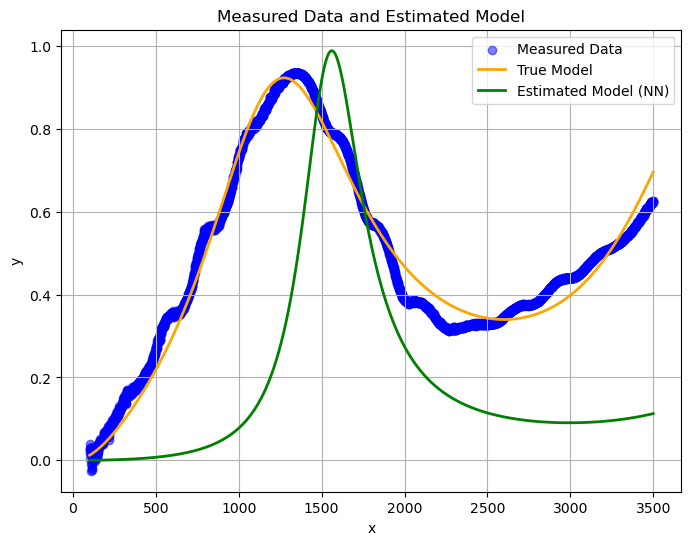

In [11]:

# 6. Use the trained model to predict the optimal parameters
np.random.seed(12)
nrandomparams= 10000
random_params = np.array([
    [
    np.random.uniform(low=parameter_bounds['a'][0], high=parameter_bounds['a'][1]),
    np.random.uniform(low=parameter_bounds['b'][0], high=parameter_bounds['b'][1]),
    np.random.uniform(low=parameter_bounds['c'][0], high=parameter_bounds['c'][1]),
    np.random.uniform(low=parameter_bounds['d'][0], high=parameter_bounds['d'][1]),
    np.random.uniform(low=parameter_bounds['e'][0], high=parameter_bounds['e'][1])
] for _ in range(nrandomparams)])
#random_params = np.random.uniform(0.1, 5, (10, 5))  # Generate several random sets of parameters
predicted_costs = model.predict(random_params)  # Predict costs for these parameters

# Find the parameters with the minimum cost
best_index = np.argmin(predicted_costs)
best_params = random_params[best_index]
cost_at_best_params = predicted_costs[best_index]

# Print estimated parameters and cost
print("Estimated parameters:", best_params)
print("Cost at estimated parameters:", cost_at_best_params)

# 7. Plot measured data and estimated predictions
plt.figure(figsize=(8, 6))

# Plot measured data with noise
plt.scatter(x_data, y_data, color='blue', label='Measured Data', alpha=0.5)

# Plot true analytical model for reference
y_true = myfun_jca(x_data, *true_params, sample_thick)
plt.plot(x_data, y_true, color='orange', label='True Model', linewidth=2)

# Predictions using the best estimated parameters
y_pred = myfun_jca(x_data, *best_params, sample_thick)
plt.plot(x_data, y_pred, color='green', label='Estimated Model (NN)', linewidth=2)

# Add labels and legend
plt.title('Measured Data and Estimated Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()